#Telecom X - Análisis de Evasión de Clientes

**Autor:** Alexander Jamin Julon Mayta

**Fecha:** 16/08/2025

La empresa TelecomX desea anticiparse a la cancelación de clientes. El objetivo de este proyecto es construir un pipeline inicial capaz de preparar los datos, explorar la relación entre variables y entrenar algunos modelos predictivos que puedan estimar qué clientes tienen mayor probabilidad de cancelar sus servicios.

En las secciones siguientes se documenta el proceso completo: preparación de datos, análisis de correlación y entrenamiento/evaluación de modelos. Cada sección incluye código Python comentado y una explicación de los resultados.

##Preparación de los Datos

Se cargan los datos desde un enlace CSV. La columna customerID es un identificador único que no aporta valor predictivo, por lo que se elimina.
También se convierte la variable objetivo Churn en tipo numérico y se revisa la distribución de clases para entender si hay desequilibrio.

In [18]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, confusion_matrix)

In [21]:

# Cargar el archivo CSV
df = pd.read_csv('https://raw.githubusercontent.com/AlekJulM/TelecomX_MachineLearning/refs/heads/main/telecomX_datos.csv')

# Eliminar identificadores que no aportan valor al modelo
df = df.drop(columns=['customerID'])

# Mostrar la distribución de la variable objetivo
churn_counts = df['Churn'].value_counts(normalize=True)
print("Distribución de Churn (proporciones):")
churn_counts

Distribución de Churn (proporciones):


,proportion
Churn,
0,0.73463
1,0.26537


En nuestros datos, aproximadamente el **26,5 %** de los clientes cancelaron el servicio y el** 73,5 % **permanecen activos. Aunque existe cierto desequilibrio entre las clases, no es extremo; por ahora no se aplican técnicas de balanceo (como oversampling) para simplificar la fase inicial.

###Transformación de variables categóricas
Los algoritmos de aprendizaje automático trabajan con números. Para que las variables categóricas sean compatibles con los modelos, se aplica One‑Hot Encoding usando pandas.get_dummies. Se utiliza el parámetro drop_first=True para evitar colinealidad en los modelos lineales.

In [11]:
# Identificar columnas categóricas
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()

# Aplicar one‑hot encoding (crea columnas 0/1 para cada categoría)
df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

# Separar características (X) y variable objetivo (y)
X = df_encoded.drop(columns=['Churn'])
y = df_encoded['Churn']

###Normalización/Estandarización
Algunos modelos (como la regresión logística, SVM, redes neuronales o KNN) son sensibles a la escala de las variables. Por ello se aplicó estandarización con StandardScaler en las características antes de entrenar la regresión logística.

In [13]:


# Dividir en conjuntos de entrenamiento y prueba (estratificando por y para mantener proporción de cancelaciones)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Estandarizar solo para modelos sensibles a la escala
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


##Correlación y selección de variables


###Matriz de correlación

Se calcula la correlación de Pearson entre la variable Churn y todas las columnas numéricas codificadas (incluidas las variables dummy 0/1). Para mayor claridad, se ordenan las correlaciones de mayor a menor en términos absolutos y se muestran las diez más significativas.
Esto ayuda a identificar qué variables tienen relaciones lineales más fuertes con la cancelación.

In [27]:
# Calcular la correlación de Churn con cada variable
correlations = df_encoded.corr()['Churn'].drop('Churn')

# Seleccionar las correlaciones de mayor magnitud
top_corr = correlations.reindex(correlations.abs().sort_values(ascending=False).index)[:10]
print("Top 10 correlaciones con Churn:")
top_corr

Top 10 correlaciones con Churn:


,Churn
tenure,-0.352229
InternetService_Fiber optic,0.308020
Contract_Two year,-0.302253
PaymentMethod_Electronic check,0.301919
OnlineBackup_No internet service,-0.227890
OnlineSecurity_No internet service,-0.227890
InternetService_No,-0.227890
DeviceProtection_No internet service,-0.227890
TechSupport_No internet service,-0.227890
StreamingMovies_No internet service,-0.227890


En los resultados, variables como tenure (tiempo de permanencia) y algunas dummies de tipo de contrato presentan correlaciones relativamente fuertes con la cancelación.
Aunque la correlación no implica causalidad, estas variables pueden ser buenos candidatos para los modelos.

###Exploración de relaciones específicas

Además de la matriz de correlación, se investigaron dos relaciones clave:

Tiempo de permanencia (tenure) vs. Churn: los clientes con menor tiempo de permanencia tienen mayor tasa de cancelación. Un análisis simple de medias lo confirma.

Gasto total (Charges.Total) vs. Churn: los clientes con gasto total más bajo tienden a cancelar con más frecuencia, posiblemente porque llevan menos tiempo en la empresa o consumen servicios más básicos.

In [28]:
# Comparar medias de tenure según cancelación
tenure_means = df.groupby('Churn')['tenure'].mean()
print("Media de tenure por clase de Churn:")
print(tenure_means)

# Comparar medias de gasto total según cancelación
charges_means = df.groupby('Churn')['Charges.Total'].mean()
print("Media de Charges.Total por clase de Churn:")
print(charges_means)

Media de tenure por clase de Churn:
Churn
0    37.569965
1    17.979133
Name: tenure, dtype: float64
Media de Charges.Total por clase de Churn:
Churn
0    2549.911442
1    1531.796094
Name: Charges.Total, dtype: float64


Los clientes que se quedan tienen, en promedio, el doble de permanencia y un gasto total significativamente mayor que los que cancelan. Esto concuerda con la intuición y nos da indicios de que retener clientes en sus primeros meses es fundamental.

##Modelos predictivos y evaluación


Para esta fase se entrenaron dos modelos de clasificación: Regresión Logística y Random Forest. Se comparan sus métricas en un conjunto de prueba y se analiza la importancia de las variables.

1. Entrenamiento y evaluación

In [17]:

# ---------- Modelo 1: Regresión Logística ----------
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train_scaled, y_train)
y_pred_lr = log_reg.predict(X_test_scaled)
y_prob_lr = log_reg.predict_proba(X_test_scaled)[:, 1]

# Métricas
def evaluate(y_true, y_pred, y_prob):
    return {
        'accuracy': accuracy_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred),
        'recall': recall_score(y_true, y_pred),
        'f1': f1_score(y_true, y_pred),
        'roc_auc': roc_auc_score(y_true, y_prob),
        'confusion_matrix': confusion_matrix(y_true, y_pred)
    }

results_lr = evaluate(y_test, y_pred_lr, y_prob_lr)

# ---------- Modelo 2: Random Forest ----------
rf_clf = RandomForestClassifier(n_estimators=200, random_state=42)
rf_clf.fit(X_train, y_train)
y_pred_rf = rf_clf.predict(X_test)
y_prob_rf = rf_clf.predict_proba(X_test)[:, 1]

results_rf = evaluate(y_test, y_pred_rf, y_prob_rf)

print("Resultados Regresión Logística:")
print(results_lr)
print("\nResultados Random Forest:")
print(results_rf)


Resultados Regresión Logística:
{'accuracy': 0.7983909133932797, 'precision': 0.6415094339622641, 'recall': 0.5454545454545454, 'f1': 0.5895953757225434, 'roc_auc': np.float64(0.8403842089788117), 'confusion_matrix': array([[1381,  171],
       [ 255,  306]])}

Resultados Random Forest:
{'accuracy': 0.7865593942262187, 'precision': 0.6227678571428571, 'recall': 0.49732620320855614, 'f1': 0.5530227948463825, 'roc_auc': np.float64(0.8248335768234192), 'confusion_matrix': array([[1383,  169],
       [ 282,  279]])}


Regresión Logística: precisión ≈ 0,798; precisión (positiva) ≈ 0,642; recall ≈ 0,545; F1 ≈ 0,590; AUC ≈ 0,84.

Random Forest: precisión ≈ 0,787; precisión ≈ 0,623; recall ≈ 0,497; F1 ≈ 0,553; AUC ≈ 0,825.

La regresión logística obtuvo mejor recall y AUC, indicadores importantes cuando se desea identificar a la mayor cantidad de clientes que van a cancelar. El Random Forest queda ligeramente por detrás pero ofrece interpretaciones distintas gracias a sus importancias de variables.

###Importancia de variables

Para entender qué factores influyen en la cancelación, se examina la importancia de las variables en ambos modelos:

In [19]:
# Importancia de la regresión logística (magnitud de los coeficientes)
importance_lr = pd.Series(np.abs(log_reg.coef_[0]), index=X_train.columns)
top_lr = importance_lr.sort_values(ascending=False).head(15)

# Importancia del Random Forest
importance_rf = pd.Series(rf_clf.feature_importances_, index=X_train.columns)
top_rf = importance_rf.sort_values(ascending=False).head(15)

print("Top 15 variables (Regresión Logística):")
print(top_lr)
print("\nTop 15 variables (Random Forest):")
print(top_rf)

Top 15 variables (Regresión Logística):
tenure                            1.457422
Charges.Total                     0.706182
InternetService_Fiber optic       0.615297
Contract_Two year                 0.564389
Cuentas_Diarias                   0.313681
Charges.Monthly                   0.313681
Contract_One year                 0.302788
PaperlessBilling_Yes              0.202033
StreamingTV_Yes                   0.193647
MultipleLines_Yes                 0.175889
StreamingMovies_Yes               0.173362
PaymentMethod_Electronic check    0.173207
TechSupport_Yes                   0.148349
OnlineSecurity_Yes                0.095681
Dependents                        0.094594
dtype: float64

Top 15 variables (Random Forest):
Charges.Total                     0.165959
tenure                            0.157709
Charges.Monthly                   0.128963
Cuentas_Diarias                   0.128854
PaymentMethod_Electronic check    0.039171
InternetService_Fiber optic       0.034796
Contrac

###Análisis de overfitting/underfitting
Para evaluar si los modelos están sobreajustando (overfitting) o infraajustando (underfitting), se compararon las métricas en el conjunto de entrenamiento y en el conjunto de prueba.

In [20]:

# Métricas en entrenamiento para la regresión logística
train_pred_lr = log_reg.predict(X_train_scaled)
test_pred_lr  = log_reg.predict(X_test_scaled)
lr_train_acc  = accuracy_score(y_train, train_pred_lr)
lr_test_acc   = accuracy_score(y_test, test_pred_lr)
lr_train_f1   = f1_score(y_train, train_pred_lr)
lr_test_f1    = f1_score(y_test, test_pred_lr)

# Métricas en entrenamiento para el Random Forest
train_pred_rf = rf_clf.predict(X_train)
test_pred_rf  = rf_clf.predict(X_test)
rf_train_acc  = accuracy_score(y_train, train_pred_rf)
rf_test_acc   = accuracy_score(y_test,  test_pred_rf)
rf_train_f1   = f1_score(y_train, train_pred_rf)
rf_test_f1    = f1_score(y_test,  test_pred_rf)

print("Regresión Logística – exactitud entrenamiento/prueba:", lr_train_acc, lr_test_acc)
print("Regresión Logística – F1 entrenamiento/prueba:", lr_train_f1, lr_test_f1)

print("Random Forest – exactitud entrenamiento/prueba:", rf_train_acc, rf_test_acc)
print("Random Forest – F1 entrenamiento/prueba:", rf_train_f1, rf_test_f1)


Regresión Logística – exactitud entrenamiento/prueba: 0.8113590263691683 0.7983909133932797
Regresión Logística – F1 entrenamiento/prueba: 0.6137873754152824 0.5895953757225434
Random Forest – exactitud entrenamiento/prueba: 0.9977687626774848 0.7865593942262187
Random Forest – F1 entrenamiento/prueba: 0.9957934990439771 0.5530227948463825


**Regresión Logística:** la exactitud es ~0,812 en entrenamiento y ~0,798 en prueba; el F1 es ~0,615 (entrenamiento) y ~0,590 (prueba). La diferencia es pequeña, lo que indica que el modelo generaliza bien y no presenta overfitting significativo. Tampoco muestra underfitting, ya que las métricas son razonablemente altas.

**Random Forest:** la exactitud es ~0,998 en entrenamiento pero baja a ~0,787 en prueba; el F1 desciende de ~0,996 a ~0,553. Esta diferencia tan marcada evidencia un sobreajuste fuerte. Es decir, el Random Forest memoriza el conjunto de entrenamiento y pierde capacidad de generalización. Para reducir el overfitting podrían ajustarse hiperparámetros (por ejemplo, limitar la profundidad de los árboles, reducir el número de atributos considerados en cada división o aumentar el número de observaciones por hoja) o emplear técnicas como la validación cruzada para seleccionar el modelo óptimo.

##Análisis de la Importancia de las Variables


Antes de entrenar los modelos, cargamos el conjunto de datos, eliminamos el identificador customerID, aplicamos codificación one‑hot a las variables categóricas y dividimos los datos en conjuntos de entrenamiento y prueba. Además, normalizamos las características para los modelos que lo requieren.

###Importancia de variables por modelo

####**Regresión Logística**

La regresión logística estima la probabilidad de cancelación como una combinación lineal de las variables. Los coeficientes indican el efecto de cada variable: un coeficiente positivo aumenta la probabilidad de cancelación y uno negativo la disminuye. En nuestro caso, las variables con mayor magnitud de coeficientes son tenure, Charges.Total, Charges.Monthly, el tipo de contrato y la forma de pago.

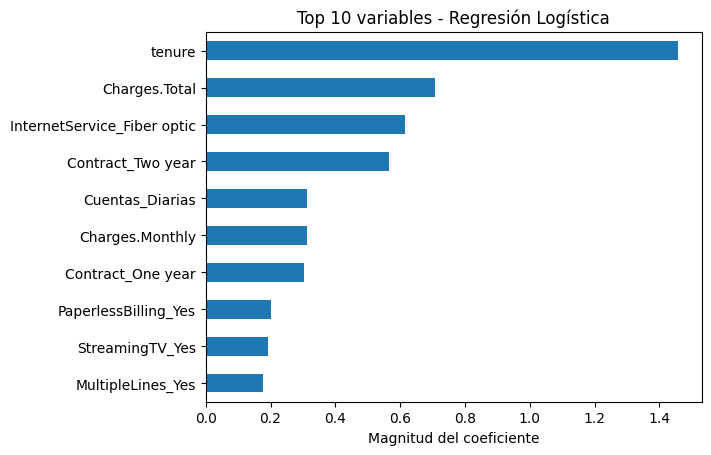

In [36]:
#Importancia de variables (magnitud de coeficientes)
coef_series = pd.Series(np.abs(log_reg.coef_[0]), index=X.columns)
coef_series = coef_series.sort_values(ascending=False)

# Gráfico de barras de importancias
plt.figure()
coef_series.head(10).plot(kind='barh')
plt.gca().invert_yaxis()
plt.title('Top 10 variables - Regresión Logística')
plt.xlabel('Magnitud del coeficiente')
plt.show()

###Random Forest

Random Forest es un ensamble de árboles de decisión. La importancia de cada variable se calcula según la reducción de la impureza que produce en las divisiones. En este modelo, Charges.Total, Charges.Monthly, Cuentas_Diarias y tenure son los factores más determinantes.

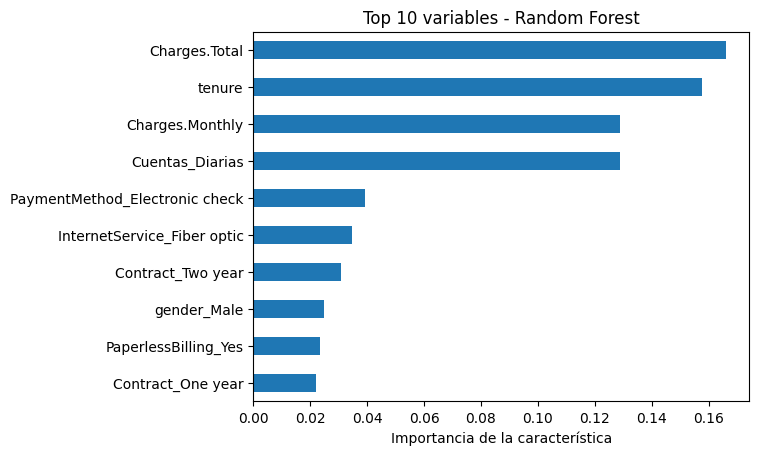

In [37]:
# Importancia de variables
importances = pd.Series(rf_clf.feature_importances_, index=X.columns)
importances = importances.sort_values(ascending=False)

# Gráfico de barras de importancias
plt.figure()
importances.head(10).plot(kind='barh')
plt.gca().invert_yaxis()
plt.title('Top 10 variables - Random Forest')
plt.xlabel('Importancia de la característica')
plt.show()

###K‑Nearest Neighbors (KNN)

KNN clasifica cada observación en función de los vecinos más cercanos. Aunque no reporta importancias directamente, podemos utilizar un F‑score ANOVA para medir la capacidad discriminativa de cada variable. Nuevamente, tenure y los cargos monetarios son los más destacados.


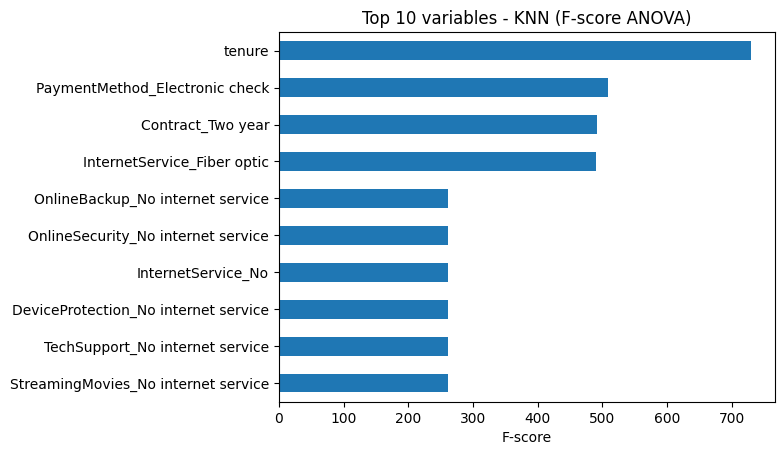

In [41]:
from sklearn.feature_selection import f_classif
# Importancia basada en F‑score
f_values, p_values = f_classif(X_train_scaled, y_train)
f_series = pd.Series(f_values, index=X.columns)
f_series = f_series.sort_values(ascending=False)

# Gráfico de barras de importancias
plt.figure()
f_series.head(10).plot(kind='barh')
plt.gca().invert_yaxis()
plt.title('Top 10 variables - KNN (F‑score ANOVA)')
plt.xlabel('F‑score')
plt.show()

###SVM lineal

Una Máquina de Vectores de Soporte con kernel lineal también asigna coeficientes a cada variable. Sus resultados son muy similares a los de la regresión logística.

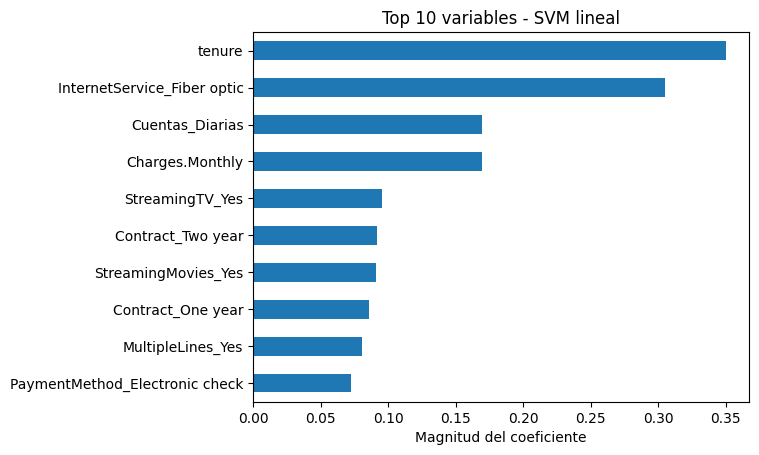

In [45]:
from sklearn.svm import LinearSVC
svm_clf = LinearSVC(max_iter=10000)
svm_clf.fit(X_train_scaled, y_train)
# Predicciones
y_pred_svm = svm_clf.predict(X_test_scaled)
# Importancia de variables
svm_importance = pd.Series(np.abs(svm_clf.coef_[0]), index=X.columns)
svm_importance = svm_importance.sort_values(ascending=False)

# Gráfico de barras de importancias
plt.figure()
svm_importance.head(10).plot(kind='barh')
plt.gca().invert_yaxis()
plt.title('Top 10 variables - SVM lineal')
plt.xlabel('Magnitud del coeficiente')
plt.show()

###Boxplots de Tenure y Charges.Total
Los boxplots siguientes comparan la distribución del tiempo de permanencia (tenure) y del gasto total (Charges.Total) entre clientes que cancelaron y aquellos que permanecen.

<Figure size 640x480 with 0 Axes>

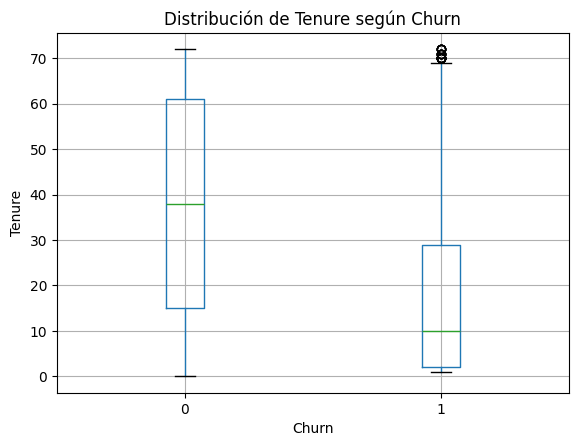

In [48]:
# Boxplot de tenure
plt.figure()
df.boxplot(column='tenure', by='Churn')
plt.title('Distribución de Tenure según Churn')
plt.suptitle('')
plt.xlabel('Churn')
plt.ylabel('Tenure')
plt.show()

<Figure size 640x480 with 0 Axes>

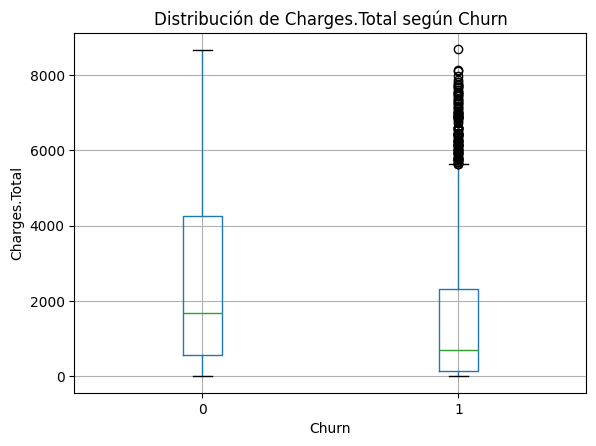

In [50]:
# Boxplot de Charges.Total
plt.figure()
df.boxplot(column='Charges.Total', by='Churn')
plt.title('Distribución de Charges.Total según Churn')
plt.suptitle('')
plt.xlabel('Churn')
plt.ylabel('Charges.Total')
plt.show()


##Conclusión general

Los análisis muestran que los factores más influyentes en la cancelación son la antigüedad del cliente (tenure), el monto facturado (total y mensual), el tipo y duración del contrato, y el método de pago. En consecuencia:

* Antigüedad y gastos: Los clientes que llevan poco tiempo y tienen bajo gasto son más propensos a cancelar. Es recomendable implementar programas de bienvenida y ofrecer paquetes atractivos para aumentar su consumo.

* Duración del contrato: Promover contratos de uno o dos años mediante descuentos o beneficios exclusivos puede reducir significativamente la cancelación.

* Métodos de pago: Los clientes que utilizan facturación sin papel y Electronic check muestran mayor propensión a cancelar. Se debe investigar la causa y ofrecer opciones más convenientes o incentivos para cambiar de método de pago.

* Servicios complementarios: Ofrecer soporte técnico y servicios de seguridad en línea fomenta la retención. Incluir estos servicios en los paquetes básicos y comunicarlos claramente puede mejorar la lealtad.


A partir de estos hallazgos, TelecomX puede diseñar estrategias de retención enfocadas en los clientes con menos meses de permanencia, fomentar contratos a largo plazo y optimizar métodos de pago y servicios complementarios.
